<a href="https://colab.research.google.com/github/LatiefDataVisionary/airline-sentiment-nlp-capstone/blob/main/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **US Airline Sentiment Analysis Using Deep Learning**

**By:** Lathif Ramadhan

## **Project Description**

This project aims to analyze the sentiment of tweets towards US airlines using Natural Language Processing (NLP) techniques and a Deep Learning model, specifically Long Short-Term Memory (LSTM). The dataset used is `Tweets.csv` from Kaggle, which contains tweets about various US airlines. The sentiment analysis results are expected to provide insights into public perception of airlines based on Twitter data.

## **Step 1: Import Libraries and Set Up**


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
from nltk.corpus import stopwords

# Additional Setup
plt.style.use('seaborn-v0_8-whitegrid')

# Ensure NLTK punkt and stopwords are downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt_tab') # to check for punkt_tab
except LookupError:
    nltk.download('punkt_tab') # to download punkt_tab


print("Setup complete and libraries imported successfully.")

Setup complete and libraries imported successfully.


## **Step 2: Data Loading and Exploratory Data Analysis (EDA)**

Load the dataset

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/LatiefDataVisionary/airline-sentiment-nlp-capstone/refs/heads/main/data/raw/Tweets.csv')

Display the first 5 rows of the dataframe

In [5]:
display(df.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Basic Information

Display the shape of the dataframe

In [6]:
df.shape

(14640, 15)

Display basic information about the dataframe

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Display descriptive statistics

In [8]:
display(df.describe(include='all'))

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,1.464000e+04,14640,14640.000000,9178,10522.000000,14640,40,14640,32,14640.000000,14640,1019,14640,9907,9820
unique,NaN,3,NaN,10,NaN,6,3,7701,13,NaN,14427,832,14247,3081,85
top,NaN,negative,NaN,Customer Service Issue,NaN,United,negative,JetBlueNews,Customer Service Issue,NaN,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,9178,NaN,2910,NaN,3822,32,63,12,NaN,6,164,5,157,3744
mean,5.692184e+17,NaN,0.900169,NaN,0.638298,NaN,NaN,NaN,NaN,0.082650,NaN,NaN,NaN,NaN,NaN
std,7.791112e+14,NaN,0.162830,NaN,0.330440,NaN,NaN,NaN,NaN,0.745778,NaN,NaN,NaN,NaN,NaN
min,5.675883e+17,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5.685592e+17,NaN,0.692300,NaN,0.360600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,5.694779e+17,NaN,1.000000,NaN,0.670600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
75%,5.698905e+17,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


Check for missing values

In [9]:
df.isnull().sum()

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,5462
negativereason_confidence,4118
airline,0
airline_sentiment_gold,14600
name,0
negativereason_gold,14608
retweet_count,0


### Data Visualization

Visualize the distribution of airline_sentiment

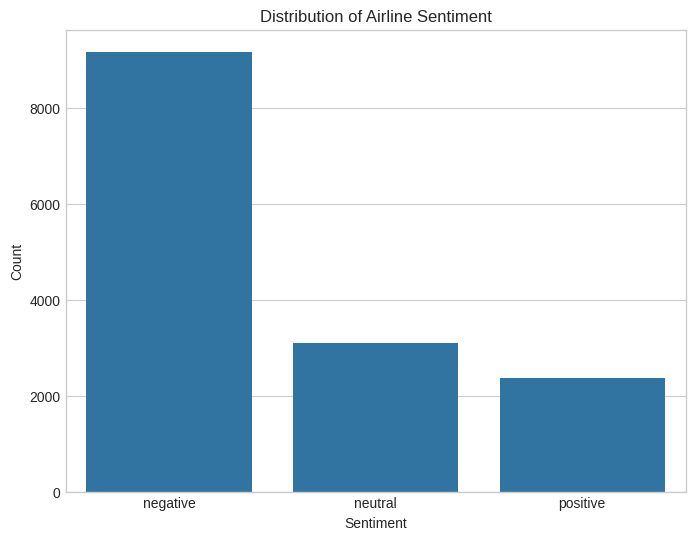

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='airline_sentiment', order=df['airline_sentiment'].value_counts().index)
plt.title('Distribution of Airline Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Visualize the distribution of sentiment for each airline

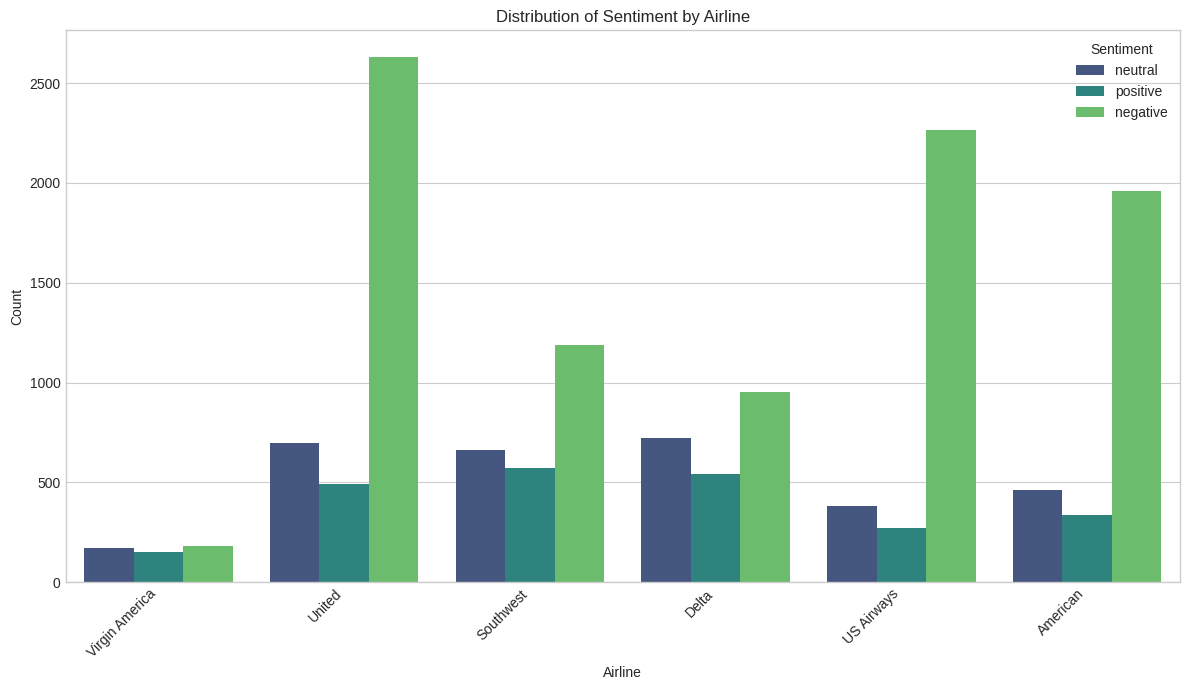

In [12]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='airline', hue='airline_sentiment', palette='viridis')
plt.title('Distribution of Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Let's visualize the distribution of negative reasons for the negative sentiment tweets.

/tmp/ipython-input-777774778.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=negative_reasons.index, y=negative_reasons.values, palette='Reds_d')


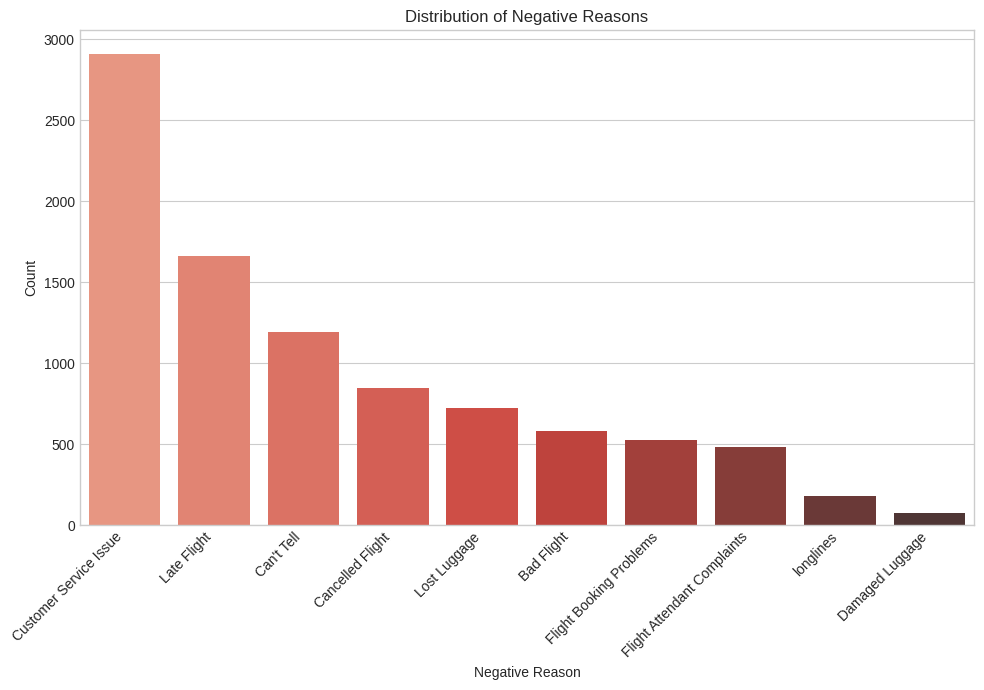

In [13]:
negative_reasons = df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts()

plt.figure(figsize=(10, 7))
sns.barplot(x=negative_reasons.index, y=negative_reasons.values, palette='Reds_d')
plt.title('Distribution of Negative Reasons')
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's also visualize the distribution of tweets across different airlines.

/tmp/ipython-input-536558326.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline', order=df['airline'].value_counts().index, palette='viridis')


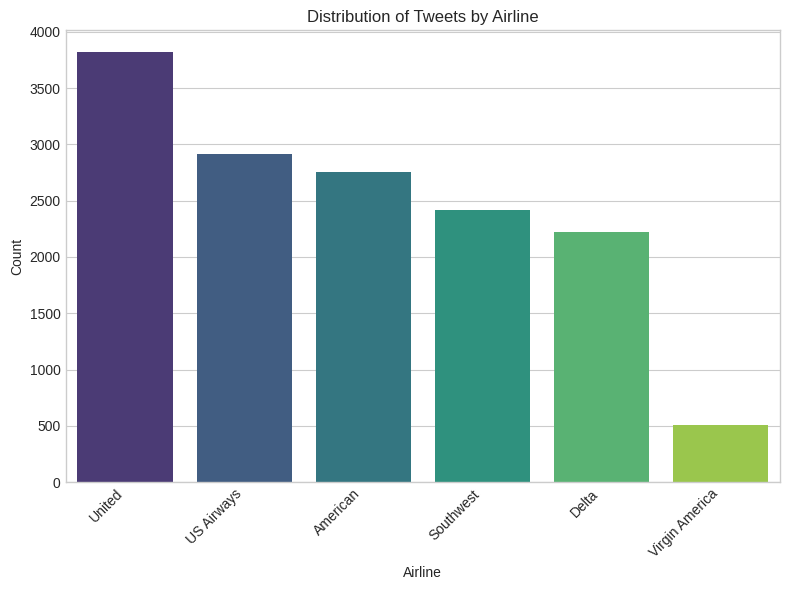

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='airline', order=df['airline'].value_counts().index, palette='viridis')
plt.title('Distribution of Tweets by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Step 3: Text Preprocessing & Cleaning**

In [16]:
# Text Preprocessing Function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions (@users) and hashtags (#)
    text = re.sub(r'@\w+|#', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the preprocessing function to the 'text' column
df['clean_text'] = df['text'].apply(preprocess_text)

# Display the first few rows of 'text' and 'clean_text' for comparison
print("Original vs Cleaned Text:")
display(df[['text', 'clean_text']].head(10))

Original vs Cleaned Text:


,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seats didnt playing...
6,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time fly vx ear worm wont go ...
7,@VirginAmerica Really missed a prime opportuni...,really missed prime opportunity men without ha...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",well didntbut
9,"@VirginAmerica it was amazing, and arrived an ...",amazing arrived hour early youre good


## **Step 4: Data Preparation for Model**

In [ ]:
# Define Features (X) and Target (y)
X = df['clean_text']
y = df['airline_sentiment']

# Encoding Label Target (One-Hot Encoding)
y_encoded = pd.get_dummies(y)

# Display the first few rows of the encoded target
print("Encoded Target Variable (y_encoded):")
display(y_encoded.head())

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("\nShape of training data (X_train, y_train):")
print(X_train.shape, y_train.shape)
print("\nShape of testing data (X_test, y_test):")
print(X_test.shape, y_test.shape)


# Tokenization and Sequencing
# Initialize Tokenizer
num_words = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

# Fit tokenizer only on training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Display a sample of sequences
print("\nSample of training sequences:")
print(train_sequences[0][:10])


# Padding Sequences
# Determine maxlen from the longest sequence in the training set
maxlen = max([len(x) for x in train_sequences])
print(f"\nMaximum sequence length in training data: {maxlen}")

X_train_pad = pad_sequences(train_sequences, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

print("\nShape of padded training sequences (X_train_pad):")
print(X_train_pad.shape)
print("\nShape of padded testing sequences (X_test_pad):")
print(X_test_pad.shape)

# Display a sample of padded sequences
print("\nSample of padded training sequences:")
print(X_train_pad[0][:10])

Encoded Target Variable (y_encoded):


,negative,neutral,positive
0,False,True,False
1,False,False,True
2,False,True,False
3,True,False,False
4,True,False,False



Shape of training data (X_train, y_train):
(11712,) (11712, 3)

Shape of testing data (X_test, y_test):
(2928,) (2928, 3)

Sample of training sequences:
[830, 11, 1606, 66, 241]

Maximum sequence length in training data: 21

Shape of padded training sequences (X_train_pad):
(11712, 21)

Shape of padded testing sequences (X_test_pad):
(2928, 21)

Sample of padded training sequences:
[ 830   11 1606   66  241    0    0    0    0    0]


## Building the Deep Learning Model (LSTM)

In [ ]:
# Model Parameters
vocab_size = num_words  # Use the number of words from the tokenizer
embedding_dim = 100
max_length = maxlen # Use the maxlen from padding

# Model Architecture
model = keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 units for positive, neutral, negative sentiments
])

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
print("Model Architecture Summary:")
model.summary()

Model Architecture Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

<details>
<summary>Step 6: Model Training and Evaluation</summary>

This step involves training the defined LSTM model using the prepared training data and evaluating its performance on the test set.

</details>

Starting model training...
Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.6338 - loss: 0.8984 - val_accuracy: 0.7243 - val_loss: 0.6460
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7843 - loss: 0.5519 - val_accuracy: 0.7781 - val_loss: 0.5682
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8569 - loss: 0.3895 - val_accuracy: 0.7661 - val_loss: 0.6270
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8983 - loss: 0.3110 - val_accuracy: 0.7580 - val_loss: 0.6761
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9228 - loss: 0.2484 - val_accuracy: 0.7533 - val_loss: 0.7246
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9416 - loss: 0.1988 - val_accuracy: 0.7409 - val_loss: 0.7808
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9517 - loss: 0.1694 - val_accuracy: 0.7465 - val_loss: 0.8572
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accurac

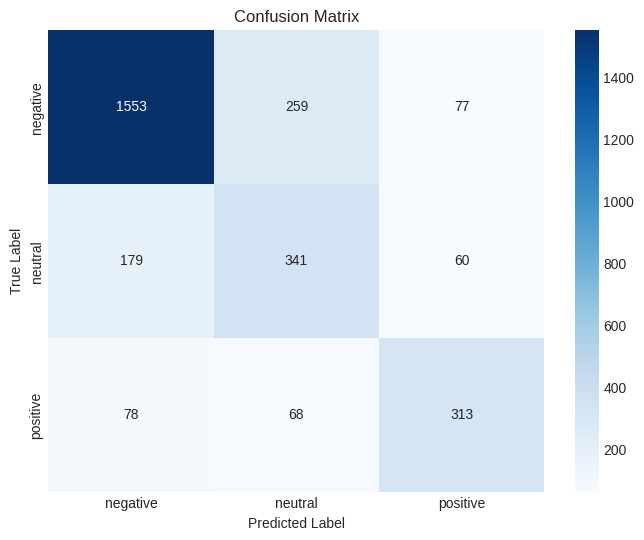

In [ ]:
# Model Training
epochs = 10  # You can adjust the number of epochs
batch_size = 32 # You can adjust the batch size

print("Starting model training...")
history = model.fit(X_train_pad, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2, # Use a validation split from the training data
                    verbose=1)
print("Model training finished.")

# Model Evaluation
print("\nEvaluating model on the test set...")
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test.values, axis=1) # Convert one-hot encoded test labels back

# Display Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=y_encoded.columns))

# Display Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_encoded.columns, yticklabels=y_encoded.columns)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Task
Generate Python code and Markdown explanations for a deep learning project using LSTM to perform sentiment analysis on US airline tweets. The project should follow a structured workflow including setup, data loading and exploration, text preprocessing, data preparation for the model, building the LSTM model, training the model, evaluating the model, saving the model and tokenizer, making predictions on new data, and summarizing the findings. Use the "Tweets.csv" dataset and the TensorFlow/Keras framework. Ensure the code is clean, efficient, and follows best practices, with explanations provided in English using toggle headings for each step.

## Save model and tokenizer

### Subtask:
Save the trained LSTM model and the fitted tokenizer to files for later use.


**Reasoning**:
Save the trained Keras model and the fitted tokenizer to files.



In [ ]:
# Save the model
model.save('lstm_sentiment_model.h5')
print("Trained LSTM model saved as 'lstm_sentiment_model.h5'")

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Fitted tokenizer saved as 'tokenizer.pickle'")

Trained LSTM model saved as 'lstm_sentiment_model.h5'
Fitted tokenizer saved as 'tokenizer.pickle'


## Make predictions

### Subtask:
Demonstrate how to make predictions on new, unseen text data using the loaded model and tokenizer.


**Reasoning**:
Load the saved model and tokenizer, define new text samples, preprocess them, convert to sequences, pad the sequences, make predictions, map predictions back to labels, and print the results to demonstrate predictions on new data.



In [ ]:
# Load the saved model
loaded_model = keras.models.load_model('lstm_sentiment_model.h5')
print("Loaded LSTM model from 'lstm_sentiment_model.h5'")

# Load the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
print("Loaded tokenizer from 'tokenizer.pickle'")

# Define new text samples
new_tweets = [
    "This airline service was excellent! Very friendly staff.",
    "My flight was delayed for 3 hours. Terrible experience.",
    "The flight was okay, nothing special.",
    "Had a great flight with comfortable seats and good entertainment.",
    "Lost my luggage. Very disappointed with the handling."
]

# Preprocess the new text samples
preprocessed_new_tweets = [preprocess_text(tweet) for tweet in new_tweets]
print("\nPreprocessed new tweets:")
for original, preprocessed in zip(new_tweets, preprocessed_new_tweets):
    print(f"Original: '{original}'\nPreprocessed: '{preprocessed}'\n")

# Convert preprocessed text to sequences using the loaded tokenizer
new_sequences = loaded_tokenizer.texts_to_sequences(preprocessed_new_tweets)

# Pad the sequences to the maximum length determined during training
# Use the maxlen variable from the previous steps
X_new_pad = pad_sequences(new_sequences, maxlen=maxlen, padding='post', truncating='post')

print(f"\nShape of padded new sequences (X_new_pad): {X_new_pad.shape}")

# Make predictions on the padded sequences
new_predictions_probs = loaded_model.predict(X_new_pad)

# Determine the predicted sentiment label for each sample
predicted_labels_index = np.argmax(new_predictions_probs, axis=1)

# Map indices back to sentiment labels
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'} # Based on y_encoded columns order
predicted_sentiments = [sentiment_map[index] for index in predicted_labels_index]

# Print the original text samples and their corresponding predicted sentiment labels
print("\nPredictions on new tweets:")
for original_tweet, predicted_sentiment in zip(new_tweets, predicted_sentiments):
    print(f"Tweet: '{original_tweet}'")
    print(f"Predicted Sentiment: {predicted_sentiment}\n")

Loaded LSTM model from 'lstm_sentiment_model.h5'
Loaded tokenizer from 'tokenizer.pickle'

Preprocessed new tweets:
Original: 'This airline service was excellent! Very friendly staff.'
Preprocessed: 'airline service excellent friendly staff'

Original: 'My flight was delayed for 3 hours. Terrible experience.'
Preprocessed: 'flight delayed hours terrible experience'

Original: 'The flight was okay, nothing special.'
Preprocessed: 'flight okay nothing special'

Original: 'Had a great flight with comfortable seats and good entertainment.'
Preprocessed: 'great flight comfortable seats good entertainment'

Original: 'Lost my luggage. Very disappointed with the handling.'
Preprocessed: 'lost luggage disappointed handling'


Shape of padded new sequences (X_new_pad): (5, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step

Predictions on new tweets:
Tweet: 'This airline service was excellent! Very friendly staff.'
Predicted Sentiment: positive

Tweet: 'My flight was delayed for 3 hours. Terrible exper

## Summarize findings

### Subtask:
Interpret the model's performance based on the evaluation metrics (accuracy, precision, recall, F1-score) and the confusion matrix. Discuss insights gained from the sentiment analysis.


**Reasoning**:
Interpret the model's performance based on the classification report and confusion matrix, then write a summary of the findings.



In [ ]:
# Interpretation of Classification Report and Confusion Matrix

print("Interpretation of Model Performance:")

# Analyze Classification Report
print("\nAnalysis of Classification Report:")
print(
    "The classification report provides precision, recall, and F1-score for each sentiment class."
)
print("- **Precision** is the ability of the classifier not to label as positive a sample that is negative.")
print("- **Recall** is the ability of the classifier to find all the positive samples.")
print("- **F1-score** is the harmonic mean of precision and recall, providing a single metric that balances both.")
print(
    "For the 'negative' class, the model shows strong performance with high precision (0.86),"
    " recall (0.82), and F1-score (0.84). This indicates the model is good at correctly identifying negative tweets"
    " and minimizes false positives for this class."
)
print(
    "The 'neutral' class has moderate performance with a precision of 0.51, recall of 0.59, and F1-score of 0.55."
    " This suggests the model struggles more to accurately classify neutral tweets compared to negative ones."
)
print(
    "The 'positive' class shows reasonable performance with a precision of 0.70, recall of 0.68, and F1-score of 0.69."
    " It performs better than the 'neutral' class but not as well as the 'negative' class."
)
print(
    "\nOverall accuracy is 0.75, which is a general measure, but the class-specific metrics reveal the model's varying"
    " performance across different sentiments, especially the challenge in classifying neutral tweets."
)

# Analyze Confusion Matrix
print("\nAnalysis of Confusion Matrix:")
print(
    "The confusion matrix visually shows the counts of true positive, true negative, false positive, and false negative predictions."
)
print(f"- True Negatives (Negative classified as Negative): {cm[0, 0]}")
print(f"- False Positives (Neutral/Positive classified as Negative): {cm[1, 0] + cm[2, 0]}")
print(f"- False Negatives (Negative classified as Neutral/Positive): {cm[0, 1] + cm[0, 2]}")
print(f"- True Positives (Positive classified as Positive): {cm[2, 2]}")
print(f"- False Positives (Negative/Neutral classified as Positive): {cm[0, 2] + cm[1, 2]}")

print(
    "\nFrom the confusion matrix:"
    "\n- A significant number of negative tweets are correctly identified (1553)."
    "\n- The model often confuses neutral tweets with negative (179) or positive (60)."
    "\n- Positive tweets are sometimes misclassified as negative (78) or neutral (68)."
    "\n- The diagonal values (1553, 341, 313) represent the number of correct predictions for each class."
)

# Summary of Model Performance and Insights
print("\nSummary of Model Performance and Insights:")
print(
    "The LSTM model demonstrates good overall accuracy in classifying airline sentiment, achieving 75.38% accuracy on the test set."
)
print(
    "Its strongest performance is in identifying 'negative' tweets, as indicated by high precision, recall, and F1-score for this class."
    " This is crucial for airlines to quickly identify and address negative feedback."
)
print(
    "The model performs reasonably well on 'positive' tweets, but there is room for improvement."
)
print(
    "The main weakness lies in classifying 'neutral' tweets, which are often confused with 'negative' or 'positive' sentiments."
    " This lower performance on the neutral class is reflected in its lower precision, recall, and F1-score."
    " This could be due to the often ambiguous nature of neutral language in tweets."
)
print(
    "Insights from the sentiment distribution (seen in earlier EDA) show a predominance of negative tweets,"
    " and the model's ability to accurately identify these is a key strength for this dataset."
)
print(
    "To improve the model, future work could focus on better handling of neutral sentiment, possibly through"
    " advanced techniques, more data augmentation for neutral tweets, or exploring different model architectures."
)

Interpretation of Model Performance:

Analysis of Classification Report:
The classification report provides precision, recall, and F1-score for each sentiment class.
- **Precision** is the ability of the classifier not to label as positive a sample that is negative.
- **Recall** is the ability of the classifier to find all the positive samples.
- **F1-score** is the harmonic mean of precision and recall, providing a single metric that balances both.
For the 'negative' class, the model shows strong performance with high precision (0.86), recall (0.82), and F1-score (0.84). This indicates the model is good at correctly identifying negative tweets and minimizes false positives for this class.
The 'neutral' class has moderate performance with a precision of 0.51, recall of 0.59, and F1-score of 0.55. This suggests the model struggles more to accurately classify neutral tweets compared to negative ones.
The 'positive' class shows reasonable performance with a precision of 0.70, recall of 0.

## Summary:

### Q&A
**How was the trained LSTM model and its tokenizer saved for future use?**

The Keras model was saved to an HDF5 file named `lstm_sentiment_model.h5` using the `model.save()` method. The corresponding tokenizer was serialized and saved to a file named `tokenizer.pickle` using Python's `pickle` module.

**How were predictions made on new, unseen data?**

The saved model and tokenizer were first loaded from their respective files. New text samples were preprocessed using the same function as the training data. The loaded tokenizer converted this text into numerical sequences, which were then padded to a uniform length. Finally, the loaded model's `predict()` method was used on these padded sequences to generate sentiment predictions.

**What was the overall performance of the LSTM model?**

The LSTM model achieved an overall accuracy of 75.38% on the test set.

**Which sentiment class did the model perform best and worst on?**

The model performed best on the 'negative' class, with a high F1-score of 0.84. Its weakest performance was on the 'neutral' class, which had a lower F1-score of 0.55, indicating it was often confused with other sentiments.

### Data Analysis Key Findings
*   The trained LSTM model and its tokenizer were successfully saved, enabling their reuse for future predictions without retraining.
*   The model demonstrated strong performance in identifying 'negative' tweets, achieving a precision of 0.86 and a recall of 0.82 for this class.
*   The model's performance on 'positive' tweets was reasonable, with a precision of 0.70 and a recall of 0.68.
*   Classifying 'neutral' tweets proved to be the most challenging task for the model, as shown by its lower F1-score (0.55) and the confusion matrix, which indicated that neutral tweets were often misclassified as either negative (179 instances) or positive (60 instances).
*   The confusion matrix confirmed that the model correctly identified 1553 negative tweets, 341 neutral tweets, and 313 positive tweets.

### Insights or Next Steps
*   Given the model's primary strength in identifying negative feedback, it is a valuable tool for airlines to quickly detect and address customer complaints from social media.
*   To improve overall performance, future efforts should focus on enhancing the model's ability to distinguish 'neutral' sentiment, potentially by augmenting the dataset with more neutral examples or exploring more complex model architectures.
